In [114]:
import pandas as pd
import numpy as np
from scipy.stats import kruskal
from statsmodels.stats.multitest import multipletests
import pandas as pd 
import ast
from scipy.stats import shapiro, ttest_ind, mannwhitneyu, kruskal

import sys
import os



# Use current working directory instead of __file__
current_dir = os.getcwd()  # The folder you run your notebook or script from

parent_dir = os.path.abspath(os.path.join(current_dir, '..'))

if parent_dir not in sys.path:
    sys.path.insert(0, parent_dir)

from results_MaBoSS_visualization.boxplot_phenotype import create_boxplot




In [115]:
drug_interest = 'Refametinib' #Pictilisib, 'Avagacestat' AZD8931 
tissue_interest = 'PAN_CANCER'
tissue_remove = 'Haematopoietic and Lymphoid'

folder_pers_models=f'../models/personalized_boolean_{drug_interest}_{tissue_interest}'
folder_result = f'../results/{drug_interest}_{tissue_interest}'



patient_res_stats_values =  pd.read_csv("../results/Refametinib_PAN_CANCER/resistant_results/only_gene_expression/single_input_on/phenotype_distribution_patients/combined_results.csv")
patient_sens_stats_values = pd.read_csv("../results/Refametinib_PAN_CANCER/sensitive_results/only_gene_expression/single_input_on/phenotype_distribution_patients/combined_results.csv")

In [116]:

# compute normality (Shapiro-Wilk test p-value ≤ 0.05 → Reject H₀ → Data is not normally distributed.)
def compute_mannwhitneyu_test_means(
    folder, patient_res_stats_values, patient_sens_stats_values, drug_interest
):
    patient_res_stats_values.rename(columns={'Unnamed: 0': 'Conditions'}, inplace=True)
    patient_sens_stats_values.rename(columns={'Unnamed: 0': 'Conditions'}, inplace=True)



    phenotypes_list_res = list(patient_res_stats_values.columns[1:])
    conditions_list_res = list(patient_res_stats_values['Conditions'])

    phenotypes_list_sens = list(patient_sens_stats_values.columns[1:])
    conditions_list_sens = list(patient_sens_stats_values['Conditions'])
   


    p_values_records_mannwhitneyu_greater = []
    for condition in conditions_list_res:
        if condition in conditions_list_sens:
            for phenotype in phenotypes_list_res:
                if phenotype in phenotypes_list_sens:
                    row_res = patient_res_stats_values[patient_res_stats_values['Conditions'] == condition]
                    stats_data_res = row_res[phenotype].values[0]

                    row_sens = patient_sens_stats_values[patient_sens_stats_values['Conditions'] == condition]
                    stats_data_sens = row_sens[phenotype].values[0]
                    stats_data_res = ast.literal_eval(stats_data_res)
                    stats_data_sens = ast.literal_eval(stats_data_sens)
                   
                    statistic, p_value_res_sens_greater = mannwhitneyu(
                        stats_data_res, stats_data_sens, alternative="greater"
                    )
        
                    p_values_records_mannwhitneyu_greater.append(
                        {
                            "Condition": condition,
                            "Phenotype": phenotype,
                            "Mannwhitneyu_P_value_Resistant": p_value_res_sens_greater,
                        }
                    )

    p_values_df_mannwhitneyu_greater = pd.DataFrame(
        p_values_records_mannwhitneyu_greater
    )
    # p_values_df_mannwhitneyu_greater.set_index(["Condition", "Phenotype"], inplace=True)
    p_values_df_mannwhitneyu_greater.set_index(["Condition"], inplace=True)

    p_values_df_mannwhitneyu_greater_sign = p_values_df_mannwhitneyu_greater[
        p_values_df_mannwhitneyu_greater["Mannwhitneyu_P_value_Resistant"] <= 0.05
    ].copy()

    choices = ["***", "**", "*"]

    conditions = [
        p_values_df_mannwhitneyu_greater_sign["Mannwhitneyu_P_value_Resistant"] < 0.001,
        (p_values_df_mannwhitneyu_greater_sign["Mannwhitneyu_P_value_Resistant"]
            >= 0.001)
        & (p_values_df_mannwhitneyu_greater_sign["Mannwhitneyu_P_value_Resistant"]< 0.01),
        (p_values_df_mannwhitneyu_greater_sign["Mannwhitneyu_P_value_Resistant"]
            >= 0.01)
        & (p_values_df_mannwhitneyu_greater_sign["Mannwhitneyu_P_value_Resistant"]<= 0.05),
    ]

    p_values_df_mannwhitneyu_greater_sign.loc[:, "Star_significant"] = np.select(
        conditions, choices, default=""
    )

    p_values_df_mannwhitneyu_greater_sign.to_csv(
        f"{folder}/sensitive_resistant_results/p_values_df_mannwhitneyu_greater_sign_{drug_interest}.csv",
        index=True,
    )


In [117]:
compute_mannwhitneyu_test_means(folder_result, patient_res_stats_values, patient_sens_stats_values, drug_interest)

In [118]:
sign_pairs = pd.read_csv('../results/Refametinib_PAN_CANCER/sensitive_resistant_results/p_values_df_mannwhitneyu_greater_sign_Refametinib.csv')
print(sign_pairs)

    Condition      Phenotype  Mannwhitneyu_P_value_Resistant Star_significant
0        TGFB  Proliferation                        0.009021               **
1     Hypoxia  Proliferation                        0.013250                *
2  Carcinogen  Proliferation                        0.016536                *
3         TNF  Proliferation                        0.004116               **


In [119]:
res_results = pd.read_csv('../results/Refametinib_PAN_CANCER/resistant_results/only_gene_expression/single_input_on/phenotype_distribution_patients/combined_results.csv')
sens_results = pd.read_csv('../results/Refametinib_PAN_CANCER/sensitive_results/only_gene_expression/single_input_on/phenotype_distribution_patients/combined_results.csv')

In [120]:
res_results

,Unnamed: 0,Proliferation,Invasion,DNA_Repair,Migration,Apoptosis
0,EGF,"[0.92918, 0.909378, 0.908251, 0.428, 0.894, 0....","[0.976017, 0.002, 0.487973, 0.5930660000000001...","[0.004, 0.004, 0.004, 0.006, 0.0, 0.005932, 0....","[0.0, 0.0, 0.102782, 0.004, 0.0, 0.002, 0.0, 0...","[0.916768, 0.992506, 0.152845, 0.457268, 0.008..."
1,FGF,"[0.938718, 0.919125, 0.902001, 0.3953810000000...","[0.98015, 0.0, 0.4878309999999999, 0.569032000...","[0.0059999999999999, 0.0, 0.002, 0.009977, 0.0...","[0.001275, 0.0, 0.036275, 0.0, 0.0, 0.002, 0.0...","[0.933081, 0.996, 0.282848, 0.5581920000000001..."
2,TGFB,"[0.460338, 0.0279999999999999, 0.4027619999999...","[0.969412, 0.975738, 0.538737, 0.7134990000000...","[0.010266, 0.0, 0.003244, 0.002, 0.0, 0.018875...","[0.0, 0.0, 0.076, 0.008, 0.0, 0.03, 0.0, 0.0, ...","[0.88697, 1.0, 0.318484, 0.5678330000000001, 0..."
3,Androgen,"[0.92918, 0.909378, 0.908251, 0.428, 0.894, 0....","[0.976017, 0.002, 0.487973, 0.5910660000000001...","[0.004, 0.004, 0.004, 0.006, 0.0, 0.005932, 0....","[0.0, 0.0, 0.102782, 0.004, 0.0, 0.002, 0.0, 0...","[0.916768, 0.992506, 0.152845, 0.457268, 0.008..."
4,Hypoxia,"[0.044585, 0.937924, 0.4604860000000001, 0.344...","[0.996, 0.002, 0.508, 0.5867530000000002, 0.00...","[0.0, 0.0, 0.0, 0.014193, 0.0, 0.046261, 0.0, ...","[0.0, 0.0, 0.051105, 0.008, 0.002, 0.002, 0.0,...","[0.956, 0.998, 0.19911, 0.4743180000000001, 0...."
5,Nutrients,"[0.875383, 0.90786, 0.921016, 0.452596, 0.8967...","[0.968, 0.0, 0.455072, 0.563489, 0.002, 0.0, 0...","[0.018, 0.006, 0.002, 0.003913, 0.0, 0.024, 0....","[0.0, 0.0, 0.044728, 0.002, 0.0, 0.0, 0.0, 0.0...","[0.88296, 0.998, 0.183184, 0.399212, 0.004, 0...."
6,Carcinogen,"[0.972832, 0.952, 0.9260010000000004, 0.508136...","[0.996, 0.002, 0.435622, 0.487153, 0.001117, 0...","[0.907548, 0.998, 0.3582680000000001, 0.995997...","[0.0, 0.0, 0.034013, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.965477, 0.994, 0.402134, 0.8590690000000001..."
7,Acidosis,"[0.929179, 0.94105, 0.941122, 0.28306000000000...","[0.981999, 0.002, 0.476001, 0.4699330000000001...","[0.004, 0.002, 0.0, 0.053138, 0.0, 0.002, 0.0,...","[0.0, 0.0, 0.051532, 0.022126, 0.0, 0.002, 0.0...","[0.918767, 0.993139, 0.172841, 0.5084440000000..."
8,TNF,"[0.016745, 0.041798, 0.359102, 0.068123, 0.373...","[0.99012, 0.906355, 0.500249, 0.78357400000000...","[0.006, 0.004763, 0.004, 0.026, 0.0, 0.057499,...","[0.0, 0.0, 0.0566109999999999, 0.006111, 0.0, ...","[0.950175, 0.98233, 0.391772, 0.49843600000000..."
9,SPOP,"[0.966731, 0.935537, 0.936498, 0.3033620000000...","[0.994356, 0.004, 0.477385, 0.5794240000000002...","[0.002, 0.0, 0.002, 0.010824, 0.0, 0.006, 0.0,...","[0.0, 0.0, 0.040226, 0.008, 0.0, 0.0, 0.0, 0.0...","[0.008, 0.994, 0.109616, 0.4501100000000001, 0..."


In [121]:
# Columns: [Unnamed: 0, Proliferation, DNA Repair, Invasion, ...]
# Unnamed: 0 contains condition names (EGF, FGF, ...)

# Step 0: Rename and set up
res_results.rename(columns={'Unnamed: 0': 'Condition'}, inplace=True)
sens_results.rename(columns={'Unnamed: 0': 'Condition'}, inplace=True)

# Step 1: Melt both
res_melted = pd.melt(res_results, id_vars='Condition', var_name='Phenotype', value_name='Expression')
res_melted['Group'] = 'Resistant'

sens_melted = pd.melt(sens_results, id_vars='Condition', var_name='Phenotype', value_name='Expression')
sens_melted['Group'] = 'Sensitive'

# Step 2: Combine
df_combined = pd.concat([res_melted, sens_melted], ignore_index=True)


In [126]:
df_combined['Expression'] = df_combined['Expression'].apply(ast.literal_eval)
df_combined = df_combined.explode('Expression')
df_combined['Expression'] = df_combined['Expression'].astype(float)  # Ensure numeric
print(df_combined)


   Condition      Phenotype  Expression      Group
0        EGF  Proliferation    0.929180  Resistant
0        EGF  Proliferation    0.909378  Resistant
0        EGF  Proliferation    0.908251  Resistant
0        EGF  Proliferation    0.428000  Resistant
0        EGF  Proliferation    0.894000  Resistant
..       ...            ...         ...        ...
99      SPOP      Apoptosis    0.002000  Sensitive
99      SPOP      Apoptosis    0.035420  Sensitive
99      SPOP      Apoptosis    0.612001  Sensitive
99      SPOP      Apoptosis    0.026000  Sensitive
99      SPOP      Apoptosis    0.040000  Sensitive

[1900 rows x 4 columns]


In [128]:
print(df_combined.index.duplicated())


[False  True  True ...  True  True  True]


ValueError: cannot reindex on an axis with duplicate labels

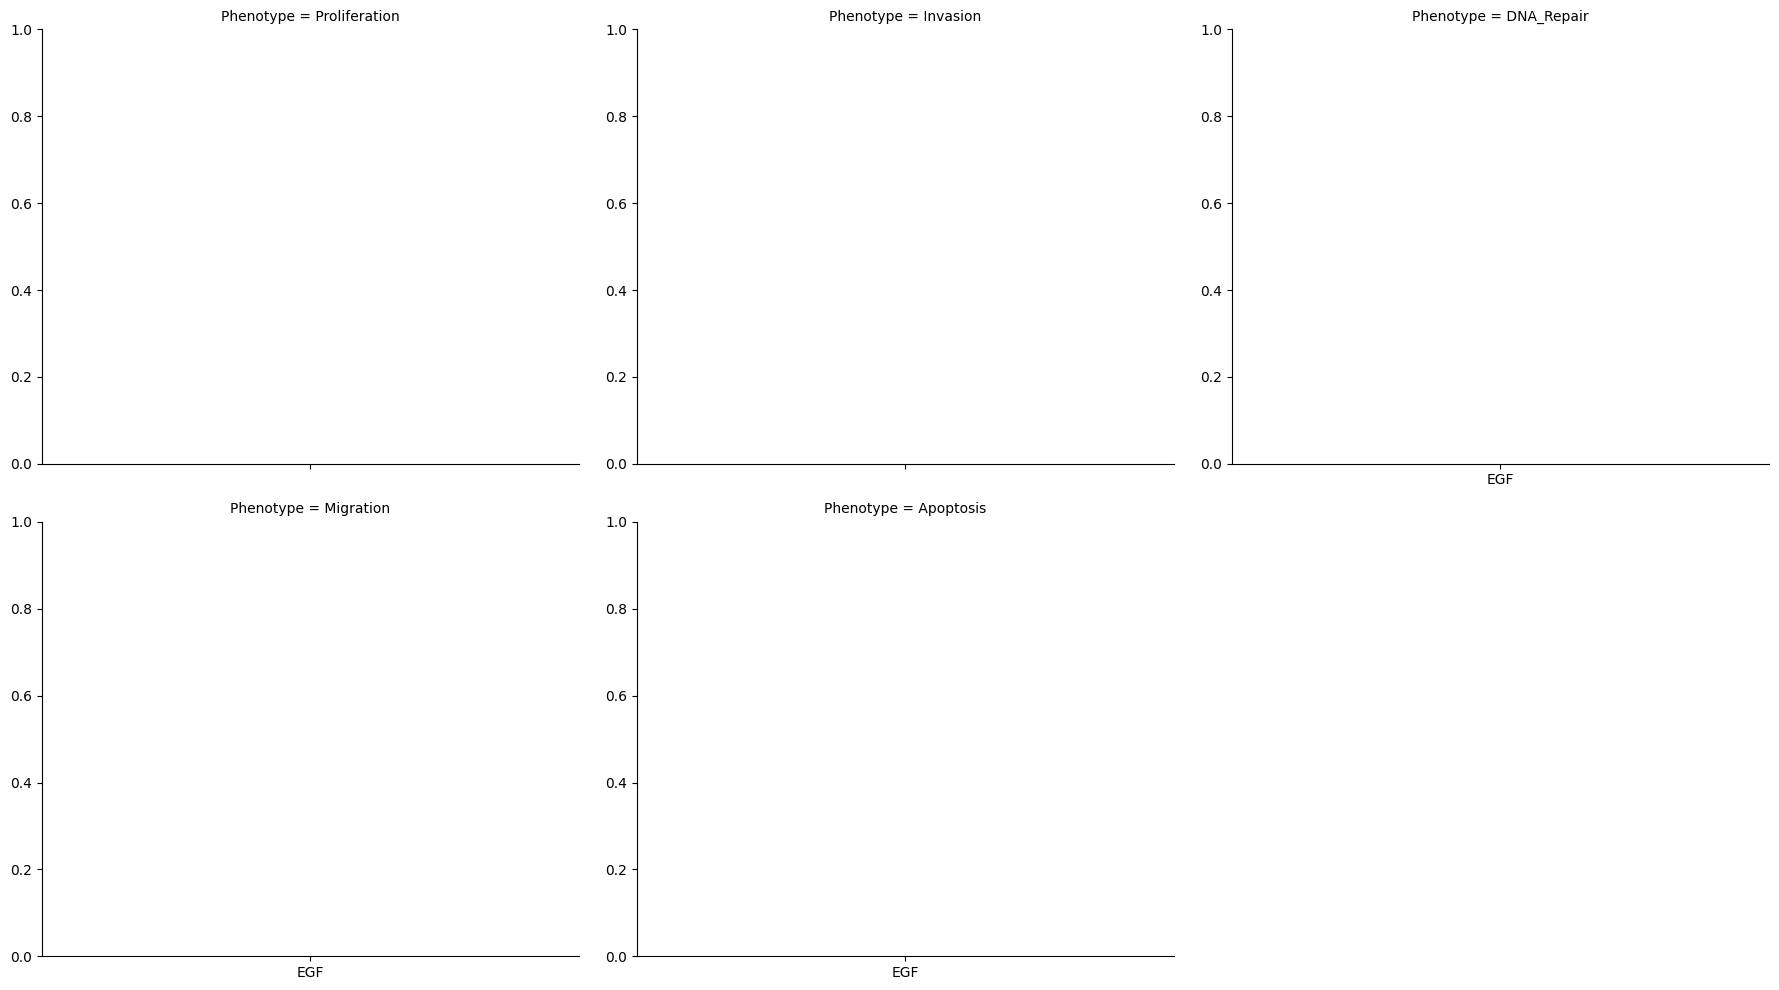

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot
g = sns.catplot(
    data=df_combined,
    kind='box',
    x='Condition',
    y='Expression',
    hue='Group',
    col='Phenotype',
    col_wrap=3,
    height=5,
    aspect=1.2,
    palette={'Resistant': '#FF7F0E', 'Sensitive': '#008000'},
    sharey=False
)

g.set_titles("{col_name}")
g.set_axis_labels("Condition", "Expression")
g.set_xticklabels(rotation=45, ha='right')
plt.tight_layout()
plt.show()


print(df_combined.index.duplicated())

